In [9]:
import numpy as np
import sys
from math import cos, radians
import matplotlib.transforms as mtransforms
from shapely.geometry import Polygon
import nest_asyncio
import math 
import datetime
from geopy import distance
from math import cos
from haversine import haversine, Unit
from pyproj import Proj
import osmnx as ox
import pyproj

#import rasterio
import random
from natsort import natsorted,realsorted, ns
from tqdm.notebook import trange, tqdm
from time import sleep
import osmnx as ox
import haversine as hs
import shutil
from numpy import asarray
from IPython import display
import os
from os import listdir
import utm
import geopandas
from pathlib import Path
import glob
import concurrent.futures
from scipy.spatial.transform import Rotation
import geotiler
 
import matplotlib.pyplot as plt
import h5py
import mplleaflet
from PIL import Image, ImageDraw
print(mplleaflet.__file__)

c:\users\bjqb7h\miniconda3\envs\perl\lib\site-packages\mplleaflet\__init__.py


In [4]:
Logname = 'AtCityBMW_Applanix-20220228T154254Z933'
path = 'C:/Users/bjqb7h/Downloads/Thesis2022/GPS DATA/GPS DATA/'
path_position = 'sensors/ApplanixDGPS'
path_orientation = 'sensors/ApplanixDGPS/orientation'
path_timestamps = 'sensors/ApplanixDGPS/timestamps'
path_meta = 'C:/Users/bjqb7h/Downloads/Thesis2022/Meta/New Meta/'
path_save ='C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_1/Dataset'
Rdirectory =r'C:\Users\bjqb7h\Downloads\Thesis2022\HD Maps_Rotate'
path_rotate = 'C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_1/Dataset/'
path_crop ='C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_Rotate'
path_cropped ='C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_Cropped'
Sep_path_save ='C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_1/Dataset/RadarGPS/'
Sep_Rdirectory = r'C:\Users\bjqb7h\Downloads\Thesis2022\HD Maps_Rotate\GPSRADAR\RotatedMAPS'
Sep_path_Rotate = r'C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_1/Dataset/RadarGPS'
Crop_directory= r'C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_Rotate/GPSRADAR/RotatedMAPS'
Crop_save_path =r'C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_Cropped/GPSRADAR'
hDF5_PATH = 'C:/Users/bjqb7h/Downloads/Thesis2022/NUMPY/New'
dir0 = r'C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_1/Dataset/RadarGPS'
dir1 = 'C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_Rotate/GPSRADAR/RotatedMAPS'
dir2 = 'C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_Cropped/GPSRADAR'



[1.64606297e+09 1.64606297e+09 1.64606298e+09]
[1.64606297e+09 1.64606297e+09 1.64606297e+09]


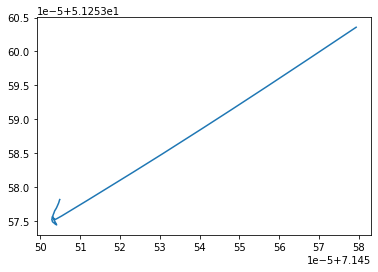

In [19]:
#Read Hdf5 filel for the Radar data and GPS data.
hf1 = h5py.File(path+Logname+'.h5','r')
dset = hf1[path_position]['position']
dset1= hf1[path_orientation]
dsetA = hf1.get(path_timestamps)
GPSTimestamp=np.array(dsetA)



hf2 = h5py.File(path_meta+Logname+'.h5','r')
dsetB= hf2.get('radar_timestamps')
dsetB=np.array(dsetB)
Radar1Timestamp = dsetB[:,0]


Radar1Timestamp = np.round(Radar1Timestamp,2)#RadarTime stamps 
GPSTimestamp= np.round(GPSTimestamp,2)#GPS

print(Radar1Timestamp[:3])
print(GPSTimestamp[:3])

#Extract all the Latitudes,Longitude and Orientation(Quaternions) 
Long=dset[:,0] #Longitude
Lat=dset[:,1]  #Latitude
q0=dset1[:,0]  #Quaternions 1
q1=dset1[:,1]  #Quaternions 2
q2=dset1[:,2]  ##Quaternions 3
q3=dset1[:,3] ##Quaternions 4

size= len(Long) #Size of the dataset ususally len(long)

nest_asyncio.apply()

plt.plot(Long,Lat)

In [20]:
    def quat_to_rotmat( q0, q1, q2, q3):
        # Converts quaternions q0, q1, q2, and q3 to a rotation matrix.

        R = np.zeros((3, 3))
        R[0, 0] = 1 - 2 * q2 ** 2 - 2 * q3 ** 2
        R[0, 1] = 2 * q1 * q2 - 2 * q0 * q3
        R[0, 2] = 2 * q0 * q2 + 2 * q1 * q3
        R[1, 0] = 2 * q1 * q2 + 2 * q0 * q3
        R[1, 1] = 1 - 2 * q1 ** 2 - 2 * q3 ** 2
        R[1, 2] = 2 * q2 * q3 - 2 * q0 * q1
        R[2, 0] = 2 * q1 * q3 - 2 * q0 * q2
        R[2, 1] = 2 * q0 * q1 + 2 * q2 * q3
        R[2, 2] = 1 - 2 * q1 ** 2 - 2 * q2 ** 2
        return R

    def GPS_data_Transformation( Long, Lat, q0, q1, q2, q3):
        RotationM = np.zeros((len(Long), 3, 3), dtype=np.float64)

        H = np.zeros((len(Long), 4, 4), dtype=np.float64)

        for i in range(0, len(q0)):
            RotationM[i, :, :] = quat_to_rotmat(q0[i], q1[i], q2[i], q3[i])
        # Generating the transformation matrix H which contain parameters
        # to transform the GPS coordinates from the antenna coordinate system to the vehicle coordinate system.

        utm_proj = Proj(proj='utm', zone=32, ellps='WGS84')
        x, y = utm_proj(Long, Lat)  # Converting the local coordinate system to world coordinate system

        for i in range(len(Long)):
            H[i, :, :] = np.eye(4)
            H[i, :3, :3] = RotationM[i, :, :]
            t = np.array([x[i], y[i], 0])  # GPS Longitude . latitude in x ,y,z
            H[i, :3, 3] = t.flatten()

        return H

    def GenerateCalibrated_data(Long, Lat, q0, q1, q2, q3):
        F4 = [1, 1, 1, 1]
        NewH1 = np.zeros((len(Long), 4, 4), dtype=np.float64)
        NewF5 = np.zeros((len(Long), 4), dtype=np.float64)

        T = np.eye(4)  # # Creating a 4*4 matrix

        R1 = Rotation.from_euler("zx", [201, 180], degrees=True).as_matrix()  #
        # Rotation and translation parameters of the antenna coordinate system relative to the vehicle coordinate system

        T[:3, :3] = R1  # moving the rotation parameters R1 to test matrix T
        T1 = T.copy()  # Creating a copy to show the transformation without translations added
        T[:3, 3] = -np.matmul(R1, np.array([-0.335, -0.424, -1.082]))  # Adding translations to the test matrix T

        H1 = GPS_data_Transformation(Long, Lat, q0, q1, q2, q3)

        for i in range(0, len(Long)):
            NewH1[i, :, :] = np.matmul(H1[i, :, :], T)  # with translations
            NewF5[i, :] = np.matmul(NewH1[i, :, :], F4)

        utm_proj = Proj(proj='utm', zone=32, ellps='WGS84')
        longitude, latitude = utm_proj(NewF5[:, 0], NewF5[:, 1], inverse=True)

        return longitude, latitude

#     def add_gaussian_noise(x,y):
#         noise = np.random.multivariate_normal(mean=[0, 0], cov=[[0.0000000005, 0], [0, 0.0000000005]], size=x.shape)
#         #noise = np.clip(noise, -10, 10)
#         x_noisy = x + noise[:, 0]
#         y_noisy = y + noise[:, 1]
#         return x_noisy, y_noisy

    def add_gaussian_noise(Long, Lat):
        cov_matrix = np.array([[0.0000000005, 0], [0, 0.0000000005]])
        noise = np.random.multivariate_normal(mean=[0, 0], cov=cov_matrix, size=Long.size)

        # Calculate the magnitude of the noise
        magnitudes = np.linalg.norm(noise, axis=1, keepdims=True)

        # Normalize the noise vectors to have the same direction
        normalized_noise = noise / magnitudes

        # Adjust the magnitude of the noise vectors based on a scaling factor
        scaling_factor = 1.0  # Adjust this value to control the magnitude of the noise
        adjusted_noise = normalized_noise * magnitudes * scaling_factor

        # Add the adjusted noise to the longitude and latitude
        x_noisy = Long + adjusted_noise[:, 0]
        y_noisy = Lat + adjusted_noise[:, 1]

        return x_noisy, y_noisy

    def BBOX_Generation(Lat, Long):
        padding_Lat = 0.001750
        Padding_long = 0.001750
        bbox = (min(Lat) - padding_Lat, max(Lat) + padding_Lat, min(Long) - Padding_long, max(Long) + Padding_long)
        gr = ox.graph_from_bbox(*bbox, network_type='all')
        geo = ox.geometries_from_bbox(*bbox, tags={'building': True})
        return gr, geo, bbox
    
    def Convert_To_M(Lat, Long):
        X, Y, O, P = utm.from_latlon(Lat, Long)
        X1 = X + 80  # 80 meter to match the semseg grid
        Y1 = Y + 80
        NewLat,NewLong = utm.to_latlon(X1, Y1, O, P)
        diff_Lat = NewLat - Lat
        diff_Long = NewLong - Long
        return diff_Long, diff_Lat
    
    def get_fig(bbox=None, size_inches=(15, 15)):

        fig, ax = plt.subplots(frameon=False)
        fig.set_size_inches(*size_inches)
        ax.set_facecolor("green")
        plt.close(fig)
        ox.plot.plot_figure_ground(gr, node_size=0, network_type='all', ax=ax, edge_color="black", bgcolor='blue',bbox=bbox,default_width=18)
        ox.plot.plot_footprints(geo, ax=ax, bgcolor='green', bbox=bbox)
        plt.close()
        return fig
    
    def crop_center(pil_img, crop_width, crop_height):
        img_width, img_height = 160,160
        return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))
    
    def Save_Maps_Sep(Lat, Long, DIFF_LAT, DIFF_LONG, i):
        Sep_path_save = 'C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_1/Dataset/RadarGPS/'
        North = Lat - DIFF_LAT
        South = Lat + DIFF_LAT
        East = Long - DIFF_LONG
        West = Long + DIFF_LONG
        print(North,South,East,West)
        fig = get_fig(bbox=(North, South, East, West), size_inches=(6, 6))
        fig.savefig(Sep_path_save + 'Save%d.png' % i, bbox_inches='tight', pad_inches=0)
        
    def Crop_image_Sep(i):
        Crop_directory = r'C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_1/Dataset/RadarGPS/'
        Crop_save_path = r'C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_Cropped/GPSRADAR'
        os.chdir(Crop_directory)
        im = Image.open(Crop_directory+ '/Save%d.png'%i)
        im_new = crop_center(im, 160, 160)
        im_new.save(Crop_save_path +'/Cropped%d.png'%i, quality=100)
        
        
    def quat2eulers(q0:float, q1:float, q2:float, q3:float):
    
        #Compute yaw-pitch-roll Euler angles from a quaternion.
    
        #Args
        #q0: Scalar component of quaternion.
        #q1, q2, q3: Vector components of quaternion.
    
        #Returns
        #(roll, pitch, yaw) (tuple): 321 Euler angles in radians
        #roll = math.atan2(2 * ((q2 * q3) + (q0 * q1)),q0**2 - q1**2 - q2**2 + q3**2)  # radians
        pitch = math.asin(2 * ((q1 * q3) - (q0 * q2)))
        yaw = math.atan2(2 * ((q1 * q2) + (q0 * q3)),q0**2 + q1**2 - q2**2 - q3**2)
        degree = 180/math.pi
        yaw = yaw *degree
        return yaw
    
    def CreateAngle(q0, q1, q2, q3, size):
        Angle = np.zeros(size, dtype=float)
        for i in range(size):
            Angle[i] = quat2eulers(q0[i], q1[i], q2[i], q3[i])
        return Angle
    
    def visualize_car_path(yaw_angle, longitude, latitude):
        # Convert latitude and longitude to x, y coordinates
        x = longitude  # Assuming longitude corresponds to x-axis
        y = latitude  # Assuming latitude corresponds to y-axis

        # Plot the car's path
        plt.figure(figsize=(8, 6))
        plt.plot(x, y, '-b', label='Car Path')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')

        # Plot the yaw angle
        arrow_length = 0.01 * np.max(np.abs(x-y))  # Set arrow length relative to the path length
        for i in range(len(x)):
            dx = arrow_length * np.cos(np.deg2rad(yaw_angle[i]))
            dy = arrow_length * np.sin(np.deg2rad(yaw_angle[i]))
            plt.arrow(x[i], y[i], dx, dy, color='r', width=0.001, head_width=0.02, alpha=0.5)

        plt.legend()
        plt.grid(True)
        plt.show()

Noise_Long = np.load(f'C:\\Users\\bjqb7h\\Downloads\\Thesis2022\\GT TRANSLATIONS\\TRUE NOISE\\DXGTNEW_AtCityBMW_Applanix-20220228T154254Z933.npy')
Noise_Lat = np.load(f'C:\\Users\\bjqb7h\\Downloads\\Thesis2022\\GT TRANSLATIONS\\TRUE NOISE\\DYGTNEW_AtCityBMW_Applanix-20220228T154254Z933.npy')  

print(Noise_Long[1],Noise_Lat[1])

-1.8937170732238167e-05 3.70087292602881e-05


In [21]:
AngleOFROTATIOn = CreateAngle(q0, q1, q2, q3,l1.size)
AngleOFROTATIOn=AngleOFROTATIOn[dgps_sync]

NameError: name 'l1' is not defined

In [22]:
#visualize_car_path(AngleOFROTATIOn[:1600], org_long[:1600],org_lat[:1600])
#print(AngleOFROTATIOn)
plt.plot(AngleOFROTATIOn)
plt.xlabel("Frames")
plt.ylabel(" Yaw angle in degrees")

NameError: name 'AngleOFROTATIOn' is not defined

In [23]:
l1,l2 = GenerateCalibrated_data(Long, Lat, q0, q1, q2, q3)
# NLong,NLat=add_gaussian_noise(l1,l2)
# utm_proj = Proj(proj='utm', zone=32, ellps='WGS84')
# x, y = utm_proj(l1, l2)

print(len(l1))

# GPS_Long,GPS_Lat = utm_proj(NLong, NLat, inverse=True)

print(NLong[1])

plt.plot(l1,l2)
mplleaflet.display()

4296


NameError: name 'NLong' is not defined

In [24]:

dgps_sync = []
for i in range(len(GPSTimestamp)):
    matching_indices = np.where(np.isclose(Radar1Timestamp, GPSTimestamp[i], rtol=1e-6))[0]
    if len(matching_indices) > 0:
        # Append the first matching index to dgps_sync array
        dgps_sync.append(matching_indices[0])

A = len(dgps_sync)
print(A)
matching_timestamps = Radar1Timestamp[dgps_sync]
print(matching_timestamps)

4296
[1.64606297e+09 1.64606297e+09 1.64606297e+09 ... 1.64606297e+09
 1.64606297e+09 1.64606297e+09]


In [25]:



dgps_ts = GPSTimestamp
radar_ts = Radar1Timestamp

dgps_sync = []
for i in range(len(GPSTimestamp)):
    # Check if a match is found with any radar timestamp
    if (GPSTimestamp[i] == Radar1Timestamp[:]).any():
        # Append index to dgps_sync array
        dgps_sync.append(i)
        
        
A=len(dgps_sync)
org_lat =np.zeros(A,dtype =np.float64)
org_long =np.zeros(A,dtype =np.float64)
gps_lat =np.zeros(A,dtype =np.float64)
gps_long =np.zeros(A,dtype =np.float64)
org_lat = l2[dgps_sync]
org_long = l1[dgps_sync]

gps_lat = org_lat + Noise_Lat[dgps_sync]
gps_long = org_long +Noise_Long[dgps_sync]
# gps_lat = org_lat +Noise_Lat
# gps_long = org_long + Noise_Long

print(len(dgps_sync))

plt.plot(gps_long,gps_lat,'b-')
mplleaflet.display()

860


c:\users\bjqb7h\miniconda3\envs\perl\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [89]:
#plt.plot(gps_long[:2068],gps_lat[:2068],'r-')



#plt.plot(gps_long,gps_lat,'r-',label=" GPS DATA ")

#plt.legend()
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()
#mplleaflet.display()
print(org_long[1:10],gps_long[1:10])

[7.14560587 7.14560431 7.14560277 7.14560127 7.14559978 7.14559833
 7.1455969  7.1455955  7.14559413] [7.14620195 7.14597872 7.14698635 7.14387043 7.14549432 7.14243501
 7.14564201 7.14527368 7.15059983]


0.00011109930665038502 -0.00012348714067134396
0.00011748697935522592 -0.0001173396921965541


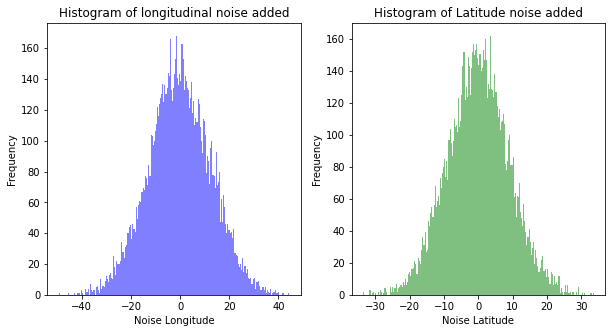

In [36]:
noise = np.random.multivariate_normal(mean=[0, 0], cov=[[0.000000001, 0], [0, 0.000000001]], size=l1.shape)
print(noise[:,0].max(),noise[:,0].min())
print(noise[:,1].max(),noise[:,1].min())
# Plot histograms of the translations
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(noise[:,0]/0.0000025, bins=216, color='blue', alpha=0.5)
axs[0].set_xlabel('Noise Longitude')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of longitudinal noise added')

axs[1].hist(noise[:,1]/0.0000035, bins=216, color='green', alpha=0.5)
axs[1].set_xlabel('Noise Latitude')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Latitude noise added')

plt.show()

# mse_meters5 = calculate_mse_meters(org_long,org_lat,gps_long,gps_lat)
# print(mse_meters5)

# rmse_error = calculate_rmse(org_long,org_lat,gps_long,gps_lat)
# print("RMSE Error:", rmse_error)



In [55]:
def calculate_rmse(dgps_longitude, dgps_latitude, gps_longitude, gps_latitude):
    assert len(dgps_longitude) == len(gps_longitude), "Arrays must have the same length"
    assert len(dgps_latitude) == len(gps_latitude), "Arrays must have the same length"

    squared_diff_sum = 0.0
    num_frames = len(dgps_longitude)

    for i in range(num_frames):
        dgps_long = dgps_longitude[i]
        dgps_lat = dgps_latitude[i]
        gps_long = gps_longitude[i]
        gps_lat = gps_latitude[i]
        diff_long = dgps_long - gps_long
        diff_lat = dgps_lat - gps_lat
        squared_diff_sum += (diff_long ** 2 + diff_lat ** 2)

    mean_squared_diff = squared_diff_sum / num_frames
    rmse = math.sqrt(mean_squared_diff)
    conversion_factor_latitude = 111000

    return rmse*conversion_factor_latitude

def calculate_mse(original_latitude, original_longitude, new_latitude, new_longitude):
    mse = 0
    for x1, y1, x2, y2 in zip(original_latitude, original_longitude, new_latitude, new_longitude):
        mse += (x1 - x2) ** 2 + (y1 - y2) ** 2
    mse = mse / len(original_latitude)
    return math.sqrt(mse)

def calculate_mse_meters(original_latitude, original_longitude, new_latitude, new_longitude):
    mse = 0
    for x1, y1, x2, y2 in zip(original_latitude, original_longitude, new_latitude, new_longitude):
        lat1, lon1, lat2, lon2 = map(math.radians, [x1, y1, x2, y2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
        c = 2 * math.asin(math.sqrt(a))
        m = 6371000 * c
        mse += m ** 2
    mse = mse / len(original_latitude)
    return math.sqrt(mse)

def calculate_sse_meters(original_latitude, original_longitude, new_latitude, new_longitude):
    sse = 0
    for x1, y1, x2, y2 in zip(original_latitude, original_longitude, new_latitude, new_longitude):
        lat1, lon1, lat2, lon2 = map(math.radians, [x1, y1, x2, y2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
        c = 2 * math.asin(math.sqrt(a))
        m = 6371000 * c
        sse += m ** 2
    return sse

def calculate_sse(original_latitude, original_longitude, new_latitude, new_longitude):
    return np.sum((original_latitude - new_latitude)**2 + (original_longitude - new_longitude)**2)

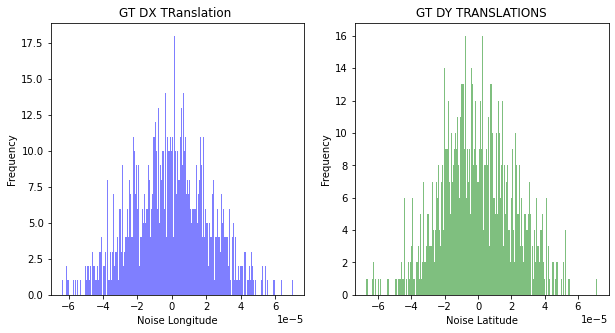

[ 2.73908492e-05  8.34521358e-06  5.24176002e-06  1.93700081e-05
 -2.42317895e-05 -1.47655297e-06 -4.42864702e-05  6.31455498e-07
 -4.50547404e-06  7.00796940e-05]
[ 2.49004441e-06 -9.23388370e-06 -4.07758131e-05 -2.06642707e-05
 -1.00092386e-05  2.54772460e-05 -1.32881665e-05  6.57763150e-06
 -5.30774755e-06 -6.31637069e-06]


In [125]:
    
dx_gt = Noise_Long[dgps_sync]
dy_gt = Noise_Lat[dgps_sync]


# dx_gt=dx_gt[dgps_sync]
# dy_gt=dy_gt[dgps_sync]

# np.save(r'C:\Users\bjqb7h\Downloads\Thesis2022\GT TRANSLATIONS\\'+'dxTrue',dx_gt)
# np.save(r'C:\Users\bjqb7h\Downloads\Thesis2022\GT TRANSLATIONS\\'+'dyTrue',dy_gt)


# Plot histograms of the translations
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(dx_gt, bins=216, color='blue', alpha=0.5)
axs[0].set_xlabel('Noise Longitude')
axs[0].set_ylabel('Frequency')
axs[0].set_title('GT DX TRanslation ')

axs[1].hist(dy_gt, bins=216, color='green', alpha=0.5)
axs[1].set_xlabel('Noise Latitude')
axs[1].set_ylabel('Frequency')
axs[1].set_title('GT DY TRANSLATIONS')

plt.show()

print(dx_gt[:10])
print(dy_gt[:10])


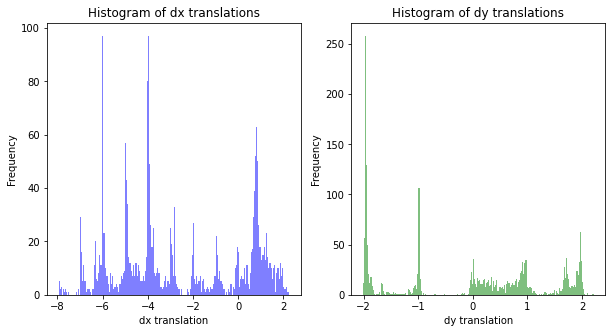

In [126]:

dx = np.load(f'C:\\Users\\bjqb7h\\Downloads\\Thesis2022\\dxdy\\DX_AR_dx_bounds_-12_12_-12_12.npy')
dy = np.load(f'C:\\Users\\bjqb7h\\Downloads\\Thesis2022\\dxdy\\DY_AR_dy_bounds_-12_12_-12_12.npy')


# Plot histograms of the translations
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(dx, bins=216, color='blue', alpha=0.5)
axs[0].set_xlabel('dx translation')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of dx translations')

axs[1].hist(dy, bins=216, color='green', alpha=0.5)
axs[1].set_xlabel('dy translation')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of dy translations')

plt.show()

In [140]:
# original_resolution_x = 80/ 438
# original_resolution_y = 80/ 462

# print(original_resolution_x,original_resolution_y)

TRUE_GT=np.load(f'C:\\Users\\bjqb7h\\Downloads\\Thesis2022\\\GT TRANSLATIONS\\Network output\\AtCityBMW_Applanix-20220228T154254Z933_output.npy')
print(TRUE_GT.shape)
Ndx_gt=TRUE_GT[:,0]*0.000017
Ndy_gt=TRUE_GT[:,1]*0.000014
print(Ndx_gt[:4])
print(dx_gt[:4])

(860, 2)
[ 6.82467662e-06  1.35692509e-05 -7.09670796e-06  5.82338857e-06]
[2.73908492e-05 8.34521358e-06 5.24176002e-06 1.93700081e-05]


In [141]:
J=len(gps_long)
pixel_size_x=0.000014
pixel_size_y=0.000017

dx_m =np.zeros(J,dtype =np.float64)
dy_m =np.zeros(J,dtype =np.float64)
dLatm =np.zeros(J,dtype =np.float64)
dLonm =np.zeros(J,dtype =np.float64)
dLat =np.zeros(J,dtype =np.float64)
dLon =np.zeros(J,dtype =np.float64)

In [142]:

for i in range(J):
    dLonm[i] = gps_long[i]-dx_gt[i]
    dLatm[i] = gps_lat[i]-dy_gt[i]
    
    
mse_meters4 = calculate_mse_meters(org_long,org_lat,dLonm,dLatm)
mse_meters5 = calculate_mse_meters(org_long,org_lat,gps_long,gps_lat)

#ADD mean absolute data metric

print("The RMSE for the Original DGPS vs Translated GPS",mse_meters4)
print("The RMSE for the Original DGPS vs GPS",mse_meters5)



The RMSE for the Original DGPS vs Translated GPS 0.0
The RMSE for the Original DGPS vs GPS 3.4831058392699927


In [143]:

for i in range(J):
    dLon[i] = gps_long[i]-Ndx_gt[i]
    dLat[i] = gps_lat[i]-Ndy_gt[i]
    
    
mse_meters7 = calculate_mse_meters(org_long,org_lat,dLon,dLat)
mse_meters8 = calculate_mse_meters(org_long,org_lat,gps_long,gps_lat)

#ADD mean absolute data metric

print("The RMSE for the Original DGPS vs Translated GPS",mse_meters7)
print("The RMSE for the Original DGPS vs GPS",mse_meters8)


The RMSE for the Original DGPS vs Translated GPS 3.841861881114653
The RMSE for the Original DGPS vs GPS 3.4831058392699927


In [67]:
# dx_array = np.load(r'C:\Users\bjqb7h\Downloads\Thesis2022\train\dx dy results\dx.npy')  # Replace 'dx_array.npy' with the path to your dx array file
# dy_array = np.load(r'C:\Users\bjqb7h\Downloads\Thesis2022\train\dx dy results\dy.npy')


SLONG = gps_long[41:82]
SLAT = gps_lat[41:82]
Lat =np.zeros(J,dtype =np.float64)
Lon =np.zeros(J,dtype =np.float64)

for i in range(41):
    Lon[i]=SLONG[i]-dx_array[i]*0.000014
    Lat[i]=SLAT[i]-dy_array[i]*0.000017
    
mse_meters7 = calculate_mse_meters(org_long[41:82],org_lat[41:82],Lon,Lat)
mse_meters8 = calculate_mse_meters(org_long[41:82],org_lat[41:82],gps_long[41:82],gps_lat[41:82])

print("The RMSE for the frames 41-82 Original DGPS vs Translated GPS",mse_meters7)
print("The RMSE for the frames 41-82 Original DGPS vs GPS",mse_meters8)

The RMSE for the frames 41-82 Original DGPS vs Translated GPS 3.41613405667491
The RMSE for the frames 41-82 Original DGPS vs GPS 3.0270605722958264


In [421]:

dx_m1 =np.zeros(J,dtype =np.float64)
dy_m1 =np.zeros(J,dtype =np.float64)
dLatm1 =np.zeros(J,dtype =np.float64)
dLonm1 =np.zeros(J,dtype =np.float64)
for i in range(J):
    if AngleOFROTATIOn[i] > 0:
        dLatm1[i] = gps_lat[i] - dy[i] * (pixel_size_y)
        dLonm1[i] = gps_long[i] + dx[i] *(pixel_size_x)
    else:
        dLatm1[i] = gps_lat[i] + dy[i] * (pixel_size_y)
        dLonm1[i] = gps_long[i] - dx[i] *(pixel_size_x)

        
print(org_long.shape,org_lat.shape,dLonm1.shape,dLatm1.shape)
    
    
mse_meters6 = calculate_rmse(org_long,org_lat,dLonm1,dLatm1)
mse_meters7 = calculate_rmse(org_long,org_lat,gps_long,gps_lat)
from sklearn.metrics import mean_absolute_error

mae2 = mean_absolute_error((org_long,org_lat),(dLonm1,dLatm1))
mae3 = mean_absolute_error((org_long,org_lat),(gps_long,gps_lat))

#ADD mean absolute data metric

print("The RMSE for the Original DGPS vs Translated GPS",mse_meters6)
print("The RMSE for the Original DGPS vs GPS",mse_meters7)
print("The MAE for the Original DGPS vs Translated GPS",mae2*100000)
print("The MAE for the Original DGPS vs GPS",mae3*100000)

(2093,) (2093,) (2093,) (2093,)
The RMSE for the Original DGPS vs Translated GPS 6.8351210743654525
The RMSE for the Original DGPS vs GPS 9.591104619138344
The MAE for the Original DGPS vs Translated GPS 3.4617257679023887
The MAE for the Original DGPS vs GPS 4.928662917759969


In [422]:
#calculating RMSE FOR EACH FRAME
Y=660
B=3

print('NOisy GPS values are' ,gps_long[Y:Y+B],gps_lat[Y:Y+B])
print('DGPS values are' ,org_long[Y:Y+B],org_lat[Y:Y+B])
print('Translated GPS values are' ,dLonm1[Y:Y+B],dLatm1[Y:Y+B])
print(dx_gt[Y],dy_gt[Y])
print(dx[Y],dy[Y])

NOisy GPS values are [7.15164449 7.15163761 7.15163075] [51.24522705 51.24522885 51.2452307 ]
DGPS values are [7.1517658  7.15175898 7.15175217] [51.24518854 51.24518981 51.24519109]
Translated GPS values are [7.15171416 7.15169526 7.15168669] [51.24521046 51.24521209 51.24521394]
-0.00012130709651003713 3.850749831002531e-05
[-4.97644338] [-0.97580475]


In [423]:
import math

def median_absolute_deviation(dgps_lon, dgps_lat,gps_lon, gps_lat):
    # calculate differences between GPS and DGPS data
    lon_diff = dgps_lon - gps_lon
    lat_diff = dgps_lat - gps_lat
    
    # calculate median absolute deviations for longitude and latitude differences
    median_lon_diff = np.median(np.abs(lon_diff))
    median_lat_diff = np.median(np.abs(lat_diff))
    
    # calculate median absolute deviation based on Euclidean distance between the two sets of coordinates
    median_total_diff = np.median(np.sqrt(lon_diff**2 + lat_diff**2))
    
    return median_total_diff

# Calculate the mean absolute deviation (MAD)
mad = median_absolute_deviation(org_long,org_lat,dLonm,dLatm)
mad2 = median_absolute_deviation(org_long,org_lat,gps_long,gps_lat)


# # Calculate the root mean squared error (RMSE)
rmse = math.sqrt(((org_long[Y] - dLonm1[Y])**2 + (org_lat[Y] - dLatm1[Y])**2) / 2)
rmse2 = math.sqrt(((org_long[Y] - gps_long[Y])**2 + (org_lat[Y] - gps_lat[Y])**2) / 2)

print("Root Mean Square Error for Translated GPS: ", rmse*100000)
print("Root Mean Square Error for GPS: ",rmse2*100000)


Root Mean Square Error for Translated GPS:  3.9666124597829846
Root Mean Square Error for GPS:  8.99951084498265


In [424]:
rmseT =np.zeros(len(org_long),dtype =np.float64)
rmseG =np.zeros(len(org_long),dtype =np.float64)


for i in range(2081):
    rmseT[i] = (math.sqrt(((org_long[i] - dLonm1[i])**2 + (org_lat[i] - dLatm1[i])**2) / 2))*100000
    rmseG[i] = (math.sqrt(((org_long[i] - gps_long[i])**2 + (org_lat[i] - gps_lat[i])**2) / 2))*100000
    
    

np.save(r'C:\Users\bjqb7h\Downloads\Thesis2022\RMSE\\'+'RMSETRANS6',rmseT)
np.save(r'C:\Users\bjqb7h\Downloads\Thesis2022\RMSE\\'+'RMSEGPS6',rmseG)

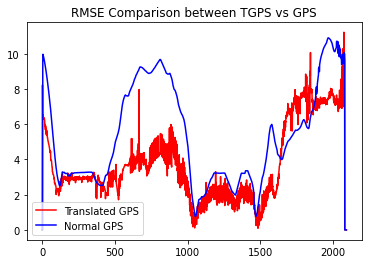

In [425]:
plt.plot(rmseT,'r-',label='Translated GPS')
plt.plot(rmseG,'b-',label='Normal GPS')
plt.legend()
plt.title("RMSE Comparison between TGPS vs GPS")
plt.show()

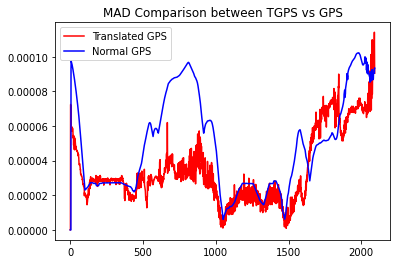

In [426]:
# Calculate the mean absolute deviation (MAD)
mad = (abs(org_long - dLonm1) + abs(org_lat - dLatm1)) / 2
mad2 = (abs(org_long - gps_long) + abs(org_lat - gps_lat)) / 2

plt.plot(mad,'r-',label='Translated GPS')
plt.plot(mad2,'b-',label='Normal GPS')
plt.legend()
plt.title("MAD Comparison between TGPS vs GPS")
plt.show()

Frames with MAD and RMSE lower than threshold:
1765
Frames with MAD and RMSE higher than threshold:
316


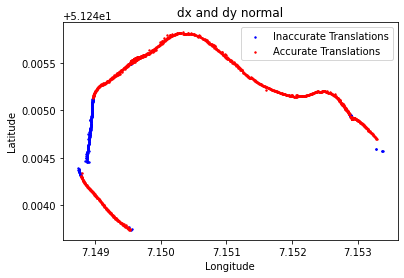

In [427]:


# Find the frames for which MAD and RMSE are lower than the threshold values
G = np.where((rmseT < rmseG))[0]
not_G = np.where((rmseT > rmseG))[0]





# Print the frames for which MAD and RMSE are lower than the threshold values
print("Frames with MAD and RMSE lower than threshold:")
print(G.size)
print("Frames with MAD and RMSE higher than threshold:")
print(not_G.size)



plt.scatter(dLonm1[not_G], dLatm1[not_G], s=2, label='Inaccurate Translations',color='blue')
plt.scatter(dLonm1[G], dLatm1[G], s=2, label='Accurate Translations',color='red')

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("dx and dy normal")
plt.show()

In [26]:
path=r'C:\Users\bjqb7h\Downloads\Thesis2022\GT TRANSLATIONS\Network output\DGPS DATA'
Logname = '\AtCityBMW_Applanix-20220228T154254Z933'
#Read Hdf5 filel for the Radar data and GPS data.
hf3 = h5py.File(path+Logname+'.h5','r')
dset = hf1[path_position]['position']








#Extract all the Latitudes,Longitude and Orientation(Quaternions) 
LongDGPS=dset[:,0] #Longitude
LatDGPS=dset[:,1]  #Latitude


size= len(Long)#Size of the dataset ususally len(long)

nest_asyncio.apply()

print(size)

LongDGPS = LongDGPS[dgps_sync]
LatDGPS = LatDGPS[dgps_sync]

plt.plot(LongDGPS,LatDGPS)
mplleaflet.display()

4296


In [52]:
GPS_NOISE=np.load(r'C:\Users\bjqb7h\Downloads\Thesis2022\GT TRANSLATIONS\Network output\TRUE DX DY\AtCityBMW_Applanix-20220228T154254Z933.npy')
dx=GPS_NOISE[:,0]*.000014
dy=GPS_NOISE[:,1]*.000017
LONGGPS=LongDGPS+dx
LATGPS=LatDGPS+dy
plt.plot(LONGGPS,LATGPS,'r-', label="Gps DATA")
plt.plot(LongDGPS,LatDGPS,'b-', label = "DGPS data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Comparison between GPS data and DGPS data",fontsize=20)
#plt.legend()
mplleaflet.display()

c:\users\bjqb7h\miniconda3\envs\perl\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [65]:
Model_OUT =np.load(r'C:\Users\bjqb7h\Downloads\Thesis2022\GT TRANSLATIONS\Network output\AtCityBMW_Applanix-20220228T154254Z933_output.npy')
print(Model_OUT.shape)
dx_m=Model_OUT[:,0]*0.0000014
dy_m=Model_OUT[:,1]*0.0000017
Model_LONG = LONGGPS+dx_m
Model_Lat = LATGPS+dy_m
plt.plot(Model_LONG,Model_Lat,'r-', label="Model Prediction")
plt.plot(LONGGPS,LATGPS,'g-')
#plt.plot(LongDGPS,LatDGPS,'b-', label ="TRUE DGPS DATA")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Comparison between Model prediction and DGPS data",fontsize=20)
#plt.legend()

mplleaflet.display()

(860, 2)


c:\users\bjqb7h\miniconda3\envs\perl\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [66]:
mse_meters6 = calculate_rmse(LongDGPS,LatDGPS,LONGGPS,LATGPS)
mse_meters7 = calculate_rmse(LongDGPS,LatDGPS,Model_LONG,Model_Lat)
from sklearn.metrics import mean_absolute_error

mae2 = mean_absolute_error((LongDGPS,LatDGPS),(LONGGPS,LATGPS))
mae3 = mean_absolute_error((LongDGPS,LatDGPS),(Model_LONG,Model_Lat))

print("Mean Square error BETWEEN GPS AND DGPS " ,mse_meters6)
print("Mean Square error BETWEEN Model Prediction AND DGPS ",mse_meters7)
print("Mean absolute error BETWEEN GPS AND DGPS " ,mae2)
print("Mean absolute error BETWEEN Model Prediction AND DGPS ",mae3)


Mean Square error BETWEEN GPS AND DGPS  3.490207416682306
Mean Square error BETWEEN Model Prediction AND DGPS  3.489691522568959
Mean absolute error BETWEEN GPS AND DGPS  1.779560588887967e-05
Mean absolute error BETWEEN Model Prediction AND DGPS  1.7787765654765545e-05


In [394]:

plt.plot(gps_long,gps_lat,'r-')
plt.plot(dLonm1,dLatm1,'g-')
plt.plot(org_long,org_lat,'b-')
mplleaflet.display()


c:\users\bjqb7h\miniconda3\envs\perl\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


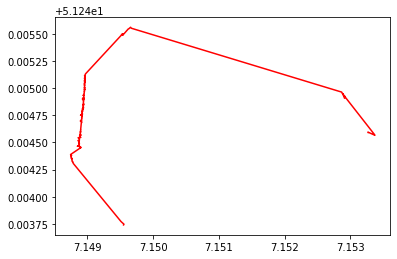

In [335]:
# plt.scatter(dLonm[G], dLatm[G], s=1, label='Accurate Translations',color='red')
# plt.scatter(dLonm[F], dLatm[F], s=1, label='Accurate Translations',color='red')
plt.plot(dLonm1[not_G], dLatm1[not_G],label='Accurate Translations',color='red')


0.0001654696395189813


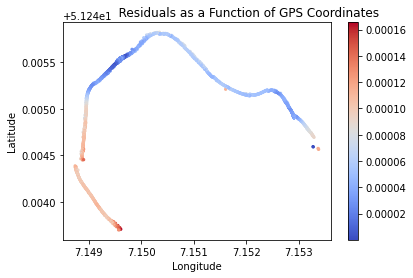

Outlier longitudes: 461
Outlier latitudes: 461


In [396]:
# assume you have two arrays of DGPS and GPS values
dgps_values = np.column_stack((org_long, org_lat))
Tgps_values = np.column_stack((dLonm1,dLatm1))
gps_values = np.column_stack((gps_long,gps_lat))


# calculate the residuals
residuals =  dgps_values-Tgps_values
    
# plot the residuals as a function of the GPS coordinates
plt.figure()
distances = np.sqrt(np.sum(residuals**2, axis=1))
print(distances.max())
plt.scatter(Tgps_values[:, 0], Tgps_values[:, 1], c=distances, cmap='coolwarm',s=5)
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('                           Residuals as a Function of GPS Coordinates')
plt.show()

# Calculate the mean residual
mean_residual = np.mean(residuals, axis=0)

# Find the indices of the residuals that are greater than the mean
outlier_indices = np.where(distances >0.00008)

# Get the longitudes and latitudes of the outliers
outlier_lons = gps_values[outlier_indices[0], 0]
outlier_lats = gps_values[outlier_indices[0], 1]

# Print the outlier longitudes and latitudes
print("Outlier longitudes:", outlier_lons.size)
print("Outlier latitudes:", outlier_lats.size)
a=outlier_indices


In [792]:
import numpy as np

# Original DGPS coordinates (longitude and latitude)
dgps_lon = x2  # shape (n_frames,)
dgps_lat = y2  # shape (n_frames,)

# Translated coordinates (longitude and latitude)
translated_lon = dLonm  # shape (n_frames,)
translated_lat = dLatm  # shape (n_frames,)


# Specify range of frames to evaluate
start_frame =1000
end_frame = 1200

# Calculate errors for all frames in range
mae_TGPS = mean_absolute_error((dgps_lon[start_frame:end_frame],dgps_lat[start_frame:end_frame]),(translated_lon[start_frame:end_frame],translated_lat[start_frame:end_frame]))
mae_GPS = mean_absolute_error((dgps_lon[start_frame:end_frame],dgps_lat[start_frame:end_frame]),(x1[start_frame:end_frame],y1[start_frame:end_frame]))

rmse_TGPS = calculate_mse(dgps_lon[start_frame:end_frame],dgps_lat[start_frame:end_frame],translated_lon[start_frame:end_frame],translated_lat[start_frame:end_frame])
rmse_GPS = calculate_mse(dgps_lon[start_frame:end_frame],dgps_lat[start_frame:end_frame],x1[start_frame:end_frame],y1[start_frame:end_frame])

# Print results
print("Translated MAE (frames {}-{}):".format(start_frame, end_frame), mae_TGPS)
print("GPS MAE (frames {}-{}):".format(start_frame, end_frame), mae_GPS)
print("Translated RMSE (frames {}-{}):".format(start_frame, end_frame), rmse_TGPS)
print("GPS RMSE (frames {}-{}):".format(start_frame, end_frame), rmse_GPS)

# # Compare with original DGPS data
# dgps_mae_lon = np.mean(np.abs(dgps_lon[start_frame:end_frame] - dgps_lon[start_frame:end_frame].mean()))
# dgps_mae_lat = np.mean(np.abs(dgps_lat[start_frame:end_frame] - dgps_lat[start_frame:end_frame].mean()))
# dgps_rmse_lon = np.sqrt(np.mean((dgps_lon[start_frame:end_frame] - dgps_lon[start_frame:end_frame].mean())**2))
# dgps_rmse_lat = np.sqrt(np.mean((dgps_lat[start_frame:end_frame] - dgps_lat[start_frame:end_frame].mean())**2))

# # Print results
# print("Longitude MAE (DGPS data):", dgps_mae_lon)
# print("Latitude MAE (DGPS data):", dgps_mae_lat)
# print("Longitude RMSE (DGPS data):", dgps_rmse_lon)
# print("Latitude RMSE (DGPS data):", dgps_rmse_lat)


Translated MAE (frames 1000-1200): 3024775.599406146
GPS MAE (frames 1000-1200): 1.6990915088368639
Translated RMSE (frames 1000-1200): 5690802.2776160585
GPS RMSE (frames 1000-1200): 3.016066687190088


In [83]:
I= np.load(r'C:\Users\bjqb7h\Downloads\Thesis2022\HD Maps_Rotate\GPSRADAR\RotatedMAPS\Rotate0.npy')

Z= np.load(r'C:\Users\bjqb7h\Downloads\Thesis2022\HD Maps_1\Dataset\RadarGPS\Save0.npy')

C=np.load(r'C:\Users\bjqb7h\Downloads\Thesis2022\HD Maps_Cropped\GPSRADAR\Cropped4.npy')

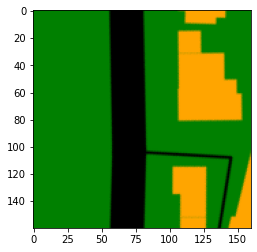

In [88]:
plt.imshow(C)

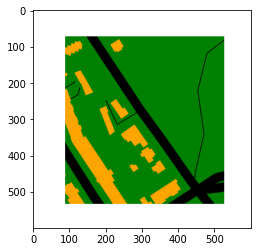

In [85]:
plt.imshow(Z)

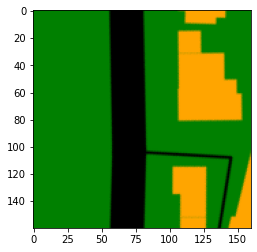

In [86]:
plt.imshow(C)
from PIL import Image, ImageDraw

def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                        (img_height - crop_height) // 2,
                        (img_width + crop_width) // 2,
                        (img_height + crop_height) // 2))

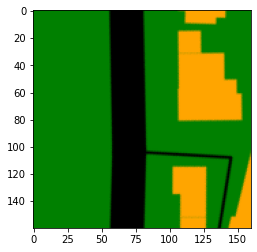

In [87]:
img = Image.fromarray(np.uint8(I))
cropped_img = crop_center(img, 160, 160)
cropped_arr = np.asarray(cropped_img)
plt.imshow(cropped_arr)

In [452]:
import torch
torch.cuda.is_available()

False